In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='595b15bd549f067e0263b525', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
Network info:

title: India bus routes (2016)
description: Networks representing bus routes in six major cities in India. Nodes represent bus stops, and an edge connects two stops that are consecutive on some bus route. Edge weight denotes the number of overlapping routes between that pair of nodes.
networkDomain: Transportation
subDomain: Public Transport
citation: A. Chatterjee, M. Manohar, and G. Ramadurai, "Statistical analysis of bus networks in India." PloS ONE 11(12), e0168478 (2016)
sourceUrl: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0168478

File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [4]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [5]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,474,1279,0,0.0,0.000333,0.0,0.000039,0.005291,0.0,0.0,0.0,6.765422e-17,1.237747e-15,1.642177e-16
1,206,376,0,0.0,0.000267,0.0,0.000016,0.003968,0.0,0.0,0.0,1.222980e-16,1.247315e-15,2.052937e-16
2,568,1492,0,0.0,0.000267,0.0,0.000099,0.010582,0.0,0.0,0.0,7.315654e-17,1.092204e-15,-1.217559e-16
3,30,1504,0,0.0,1.000000,0.0,0.000013,0.009259,0.0,0.0,0.0,4.661801e-17,1.178426e-15,3.878813e-18
4,172,1207,0,0.0,0.000267,0.0,0.000036,0.019841,0.0,0.0,0.0,7.318365e-17,1.390270e-15,1.102317e-16


## Step 2
### Link prediction model

In [6]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,86,430,0,0.0,0.000267,0.0,0.000054,0.002646,0.0,0.0,0.0,-6.981320e-18,1.062821e-15,-1.340235e-16,0.065276
1,346,937,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.283506e-17,1.179679e-15,0.000000e+00,0.509583
2,510,606,0,0.0,1.000000,0.0,0.000002,0.000000,0.0,0.0,0.0,2.112095e-17,1.190767e-15,2.578772e-17,0.466536
3,219,831,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.347939e-17,1.179301e-15,0.000000e+00,0.509583
4,45,237,0,0.0,0.000200,0.0,0.000216,0.052910,0.0,0.0,0.0,-1.541735e-16,1.328434e-15,9.058509e-17,0.705330


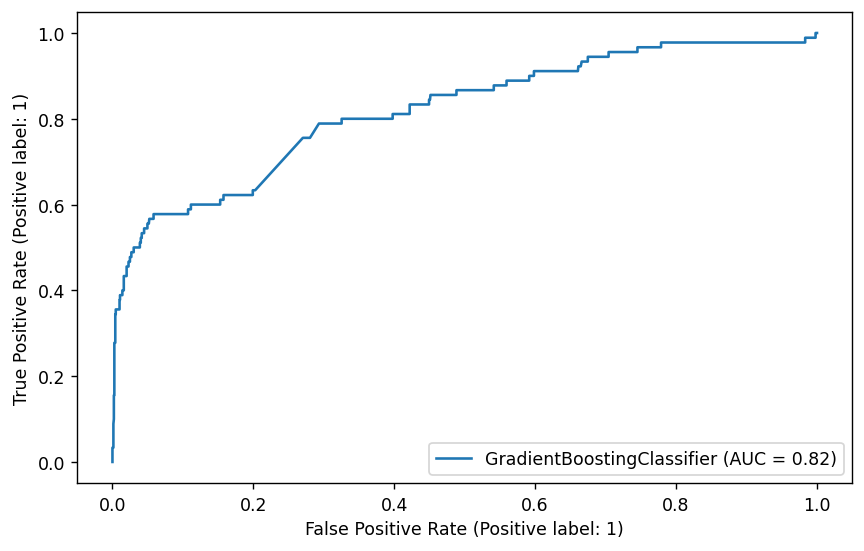

In [7]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

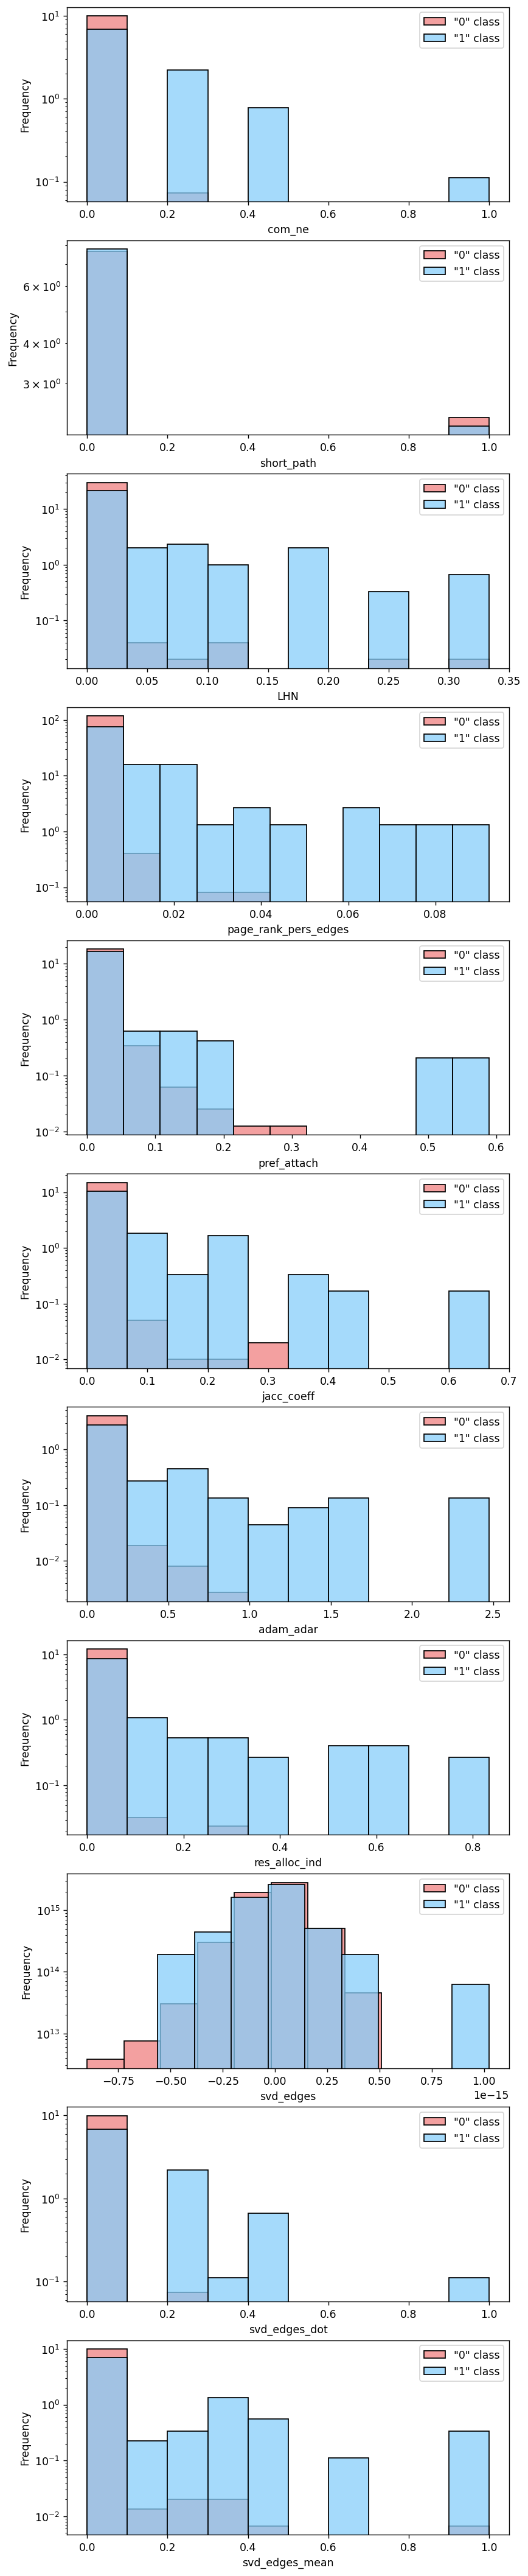

In [8]:
# distribution of features of exesting and non-existing edges

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_prediction_test[feature].max()-link_prediction_test[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='density', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Frequency')
        axs[i].set_yscale("log")
        axs[i].legend()


## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [9]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,86,430,0,0.0,0.000267,0.0,0.000054,0.002646,0.0,0.0,0.0,-6.981320e-18,1.062821e-15,-1.340235e-16,0.065276,0.065276
1,346,937,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.283506e-17,1.179679e-15,0.000000e+00,0.509583,0.509583
2,510,606,0,0.0,1.000000,0.0,0.000002,0.000000,0.0,0.0,0.0,2.112095e-17,1.190767e-15,2.578772e-17,0.466536,0.466536
3,219,831,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.347939e-17,1.179301e-15,0.000000e+00,0.509583,0.509583
4,45,237,0,0.0,0.000200,0.0,0.000216,0.052910,0.0,0.0,0.0,-1.541735e-16,1.328434e-15,9.058509e-17,0.705330,0.705330


In [10]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.05318209868240751

In [11]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,86,430,0,0.0,0.000267,0.0,0.000054,0.002646,0.0,0.0,0.0,-6.981320e-18,1.062821e-15,-1.340235e-16,0.065276,0.065276,0
1,346,937,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.283506e-17,1.179679e-15,0.000000e+00,0.509583,0.509583,0
2,510,606,0,0.0,1.000000,0.0,0.000002,0.000000,0.0,0.0,0.0,2.112095e-17,1.190767e-15,2.578772e-17,0.466536,0.466536,0
3,219,831,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.347939e-17,1.179301e-15,0.000000e+00,0.509583,0.509583,0
4,45,237,0,0.0,0.000200,0.0,0.000216,0.052910,0.0,0.0,0.0,-1.541735e-16,1.328434e-15,9.058509e-17,0.705330,0.705330,0


In [12]:
model_2 = GradientBoostingClassifier(n_estimators=500, max_depth=6, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

GradientBoostingClassifier(max_depth=6, n_estimators=500, random_state=848)

In [13]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [14]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.04770726361723533

In [15]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,352,975,0,0.0,0.000200,0.0,0.000192,0.002646,0.0,0.0,0.0,1.305379e-16,1.143958e-15,-1.208885e-17,0.031733,1,0.031733,1
1,48,1499,0,0.0,0.000067,0.0,0.005202,0.003968,0.0,0.0,0.0,-3.417405e-16,1.300582e-15,2.992398e-17,0.997542,0,0.997542,0
2,997,1287,0,0.0,0.000267,0.0,0.000016,0.001323,0.0,0.0,0.0,-1.210279e-17,1.229718e-15,3.004866e-16,0.065210,1,0.065210,0
3,437,1261,0,0.0,0.000533,0.0,0.000008,0.007937,0.0,0.0,0.0,1.572364e-16,1.160899e-15,-4.213481e-17,0.005524,1,0.005524,1
4,334,914,0,0.0,0.000200,0.0,0.000242,0.046296,0.0,0.0,0.0,-9.779504e-17,1.178132e-15,-2.038707e-17,0.029071,1,0.029071,1


In [16]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     792
0                     791
dtype: int64

In [17]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          817
0                          766
dtype: int64

In [18]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1583.000000
1,Accuracy,0.875553
2,Precision,0.875933
3,Recall,0.875553
4,F1 score,0.875520


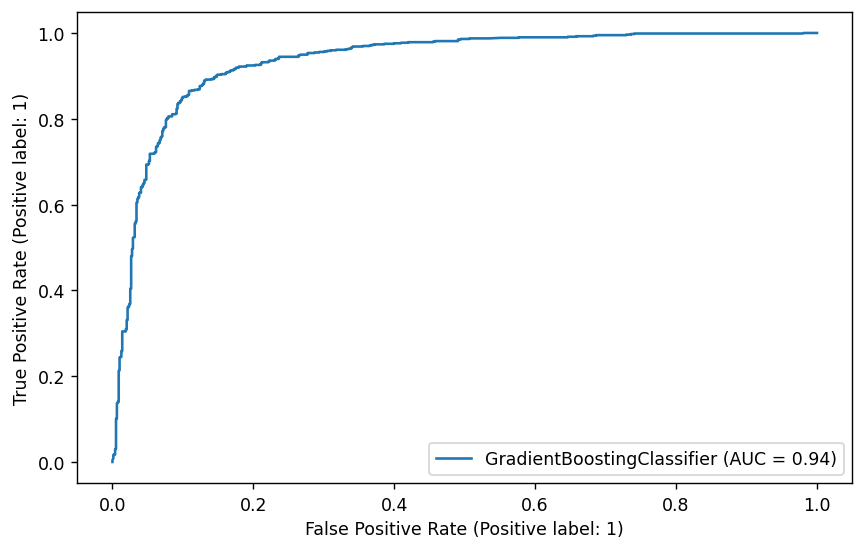

In [19]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

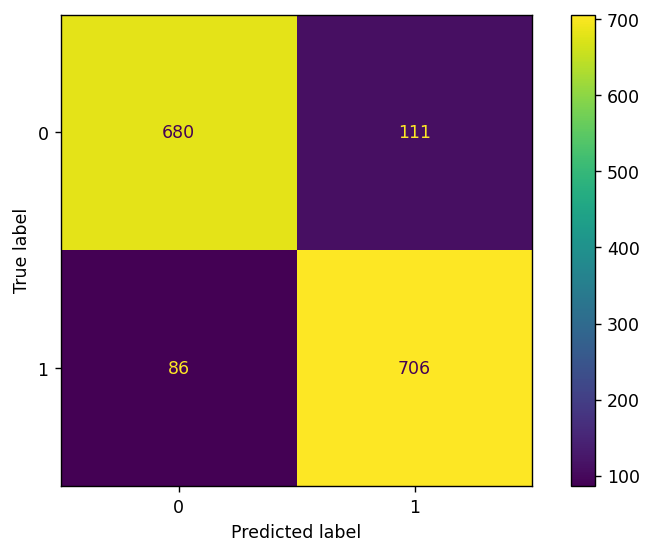

In [20]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])

In [21]:
importances_pd = pd.DataFrame()
importances_pd['Reconstruction feature importance'] = pd.Series(model.feature_importances_, index=feature_names)
importances_pd['Classification feature importance'] = pd.Series(model_2.feature_importances_, index=feature_names)
importances_pd['Diff'] = importances_pd.apply(lambda x: math.fabs(x['Reconstruction feature importance'] - x['Classification feature importance']), axis=1)

importances_pd

,Reconstruction feature importance,Classification feature importance,Diff
com_ne,0.000138,0.000327,0.000189
short_path,0.083452,0.083968,0.000516
LHN,0.000136,0.000718,0.000582
page_rank_pers_edges,0.762137,0.593596,0.168541
pref_attach,0.143584,0.314736,0.171152
jacc_coeff,0.004043,0.002036,0.002007
adam_adar,0.002435,0.002522,0.000087
res_alloc_ind,0.003834,0.001749,0.002085
svd_edges,0.000000,0.000000,0.000000
svd_edges_dot,0.000082,0.000199,0.000117


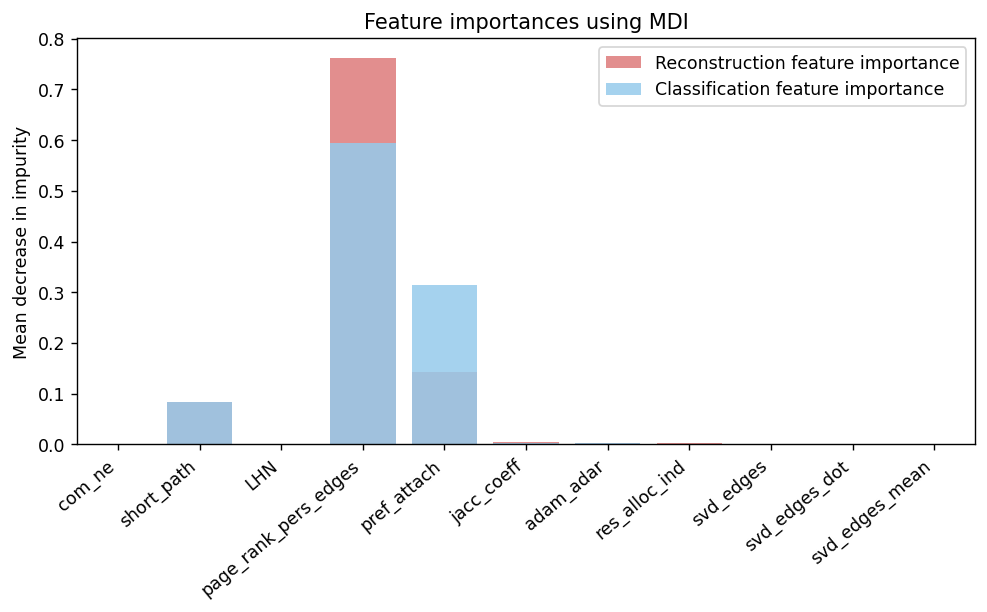

In [22]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Reconstruction feature importance', 
    label='Reconstruction feature importance',
    ax=ax, 
    color='lightcoral', 
    alpha=1
)

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Classification feature importance', 
    label='Classification feature importance', 
    ax=ax, 
    color='lightskyblue', 
    alpha=0.85
)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend()

fig.tight_layout()